<a href="https://colab.research.google.com/github/leoclementliao/colab-yolov3/blob/master/yolov3_s2_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!/opt/bin/nvidia-smi

Tue Apr 14 19:07:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## git yolo3_tf2 and pip libraries
# !git clone https://github.com/zzh8829/yolov3-tf2
!git clone https://github.com/leoclementliao/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

## Copy tfrecord dataset
% cp -r /content/drive/My\ Drive/Colab\ Notebooks/YoloV3/data /content/yolov3-tf2/data

## Download yolov3 weight (12 minutes)
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 341, done.
remote: Total 341 (delta 0), reused 0 (delta 0), pack-reused 341
Receiving objects: 100% (341/341), 4.16 MiB | 7.99 MiB/s, done.
Resolving deltas: 100% (198/198), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 32kB/s 
     |████████████████████████████████| 28.7MB 101kB/s 
     |████████████████████████████████| 3.9MB 31.5MB/s 
     |████████████████████████████████| 450kB 36.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c4a0de56f1c6c4601a7ce1196a1429554643adee34c3e04dc4e8c6b43fad08c1
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3

In [1]:
## Training parameters
epochs = 60
batch_size = 16
learning_rate = 1e-3
image_size = 416
weights_dir = '/content/yolov3-tf2/data/yolov3.weights'
checkpoint_dir = '/content/yolov3-tf2/checkpoints/yolov3.tf'

## Dataset directory
train_dir = '/content/yolov3-tf2/data/data/voc2009_train.tfrecord'
val_dir = '/content/yolov3-tf2/data/data/voc2009_val.tfrecord'
classes_dir = "/content/yolov3-tf2/data/data/voc2009.name"

## Load class names
class_names = []
with open(classes_dir, "r") as f:
    for s in f:
        class_names.append(s[:-1])

num_classes = len(class_names)
print(f'{num_classes} classes')


20 classes


In [2]:
! ls /content/yolov3-tf2/checkpoints

checkpoint		       yolov3_train.tf.data-00000-of-00002
yolov3.tf.data-00000-of-00002  yolov3_train.tf.data-00001-of-00002
yolov3.tf.data-00001-of-00002  yolov3_train.tf.index
yolov3.tf.index


In [0]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard,
    LearningRateScheduler
)

from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
import yolov3_tf2.dataset as dataset
from yolov3_tf2.utils import draw_outputs, load_darknet_weights, freeze_all
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny, YoloLoss,
    yolo_anchors, yolo_anchor_masks,
    yolo_tiny_anchors, yolo_tiny_anchor_masks
)
from yolov3_tf2.utils import freeze_all
from google.colab.patches import cv2_imshow

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [0]:
anchors = yolo_anchors
anchor_masks = yolo_anchor_masks

In [5]:
train_dataset = load_tfrecord_dataset(train_dir, classes_dir, size=image_size)
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (
    dataset.transform_images(x, image_size),
    dataset.transform_targets(y, anchors, anchor_masks, image_size)))
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.repeat()


val_dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
    dataset.transform_images(x, image_size),
    dataset.transform_targets(y, anchors, anchor_masks, image_size)))

train_dataset

<RepeatDataset shapes: ((None, 416, 416, 3), ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6), (None, 52, 52, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

In [0]:
## Load model
# !python convert.py


In [6]:
## Load model and save checkpoint files (convert pretrain model weight)
model_pretrained = YoloV3(classes=80) # The pretrain model is on coco dataset
load_darknet_weights(model_pretrained, weights_dir, tiny=False)
model_pretrained.save_weights(checkpoint_dir)

I0414 21:40:10.774545 139773843015552 utils.py:45] yolo_darknet/conv2d bn
I0414 21:40:10.783735 139773843015552 utils.py:45] yolo_darknet/conv2d_1 bn
I0414 21:40:10.790462 139773843015552 utils.py:45] yolo_darknet/conv2d_2 bn
I0414 21:40:10.797138 139773843015552 utils.py:45] yolo_darknet/conv2d_3 bn
I0414 21:40:10.804506 139773843015552 utils.py:45] yolo_darknet/conv2d_4 bn
I0414 21:40:10.811104 139773843015552 utils.py:45] yolo_darknet/conv2d_5 bn
I0414 21:40:10.817197 139773843015552 utils.py:45] yolo_darknet/conv2d_6 bn
I0414 21:40:10.823147 139773843015552 utils.py:45] yolo_darknet/conv2d_7 bn
I0414 21:40:10.829152 139773843015552 utils.py:45] yolo_darknet/conv2d_8 bn
I0414 21:40:10.835475 139773843015552 utils.py:45] yolo_darknet/conv2d_9 bn
I0414 21:40:10.843682 139773843015552 utils.py:45] yolo_darknet/conv2d_10 bn
I0414 21:40:10.850315 139773843015552 utils.py:45] yolo_darknet/conv2d_11 bn
I0414 21:40:10.856605 139773843015552 utils.py:45] yolo_darknet/conv2d_12 bn
I0414 21:40

In [0]:
## Load darknet weight in the model
model = YoloV3(size=image_size, classes=num_classes, training=True,)
# model.get_layer('yolo_darknet').set_weights(
#                 model_pretrained.get_layer('yolo_darknet').get_weights())
# freeze_all(model.get_layer('yolo_darknet'))



In [9]:
def lr_schedule(epoch):
    
    lr = 1e-3
    
    lr = 0.5*(1+np.cos((epoch/epochs)*np.pi))*lr
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

optimizer = tf.keras.optimizers.Adam(lr=lr_schedule(0),amsgrad=True)

Learning rate:  0.001


In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor=f'{output_1}_accuracy', 
                                                 patience=3, verbose=1,
                                                 factor=0.5, min_lr=1e-5)

In [0]:
# optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
loss = [YoloLoss(anchors[mask], classes=num_classes) for mask in anchor_masks]

model.compile(optimizer=optimizer, loss=loss)

callbacks = [
    ReduceLROnPlateau(verbose=1),
    lr_scheduler,
    # EarlyStopping(patience=3, verbose=1),
    # ModelCheckpoint('/content/yolov3-tf2/checkpoints/yolov3_train_{epoch}.tf',
    #                 verbose=1, save_weights_only=True),
    # TensorBoard(log_dir='logs')
]


In [11]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    steps_per_epoch= 3480// batch_size,
                    validation_steps = 448//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    )
trained_checkpoint_dir = '/content/yolov3-tf2/checkpoints/yolov3_train.tf'
model.save_weights(trained_checkpoint_dir)

Train for 217 steps, validate for 28 steps
Learning rate:  0.001
Epoch 1/60
217/217 [==============================] - 188s 866ms/step - loss: 392.3619 - yolo_output_0_loss: 35.2030 - yolo_output_1_loss: 74.7663 - yolo_output_2_loss: 269.5598 - val_loss: 69.8415 - val_yolo_output_0_loss: 16.8539 - val_yolo_output_1_loss: 16.5309 - val_yolo_output_2_loss: 23.5841
Learning rate:  0.0009993147673772868
Epoch 2/60
217/217 [==============================] - 160s 739ms/step - loss: 54.3489 - yolo_output_0_loss: 14.4650 - yolo_output_1_loss: 11.3167 - yolo_output_2_loss: 15.7961 - val_loss: 45.4935 - val_yolo_output_0_loss: 13.7321 - val_yolo_output_1_loss: 9.8682 - val_yolo_output_2_loss: 9.2368
Learning rate:  0.0009972609476841367
Epoch 3/60
217/217 [==============================] - 159s 734ms/step - loss: 47.3359 - yolo_output_0_loss: 14.4832 - yolo_output_1_loss: 10.6057 - yolo_output_2_loss: 9.6738 - val_loss: 42.8306 - val_yolo_output_0_loss: 13.8825 - val_yolo_output_1_loss: 10.1946 

In [12]:
yolo = YoloV3(classes=num_classes)
yolo.load_weights(trained_checkpoint_dir).expect_partial()
# yolo.load_weights('/content/yolov3-tf2/checkpoints/yolov3_train_3.tf').expect_partial()


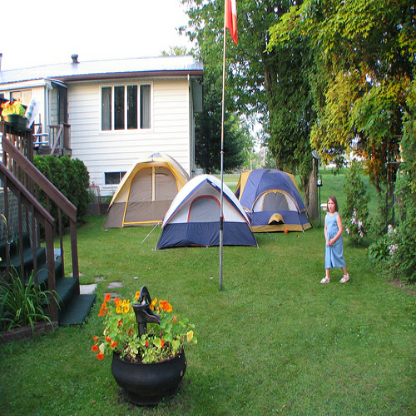

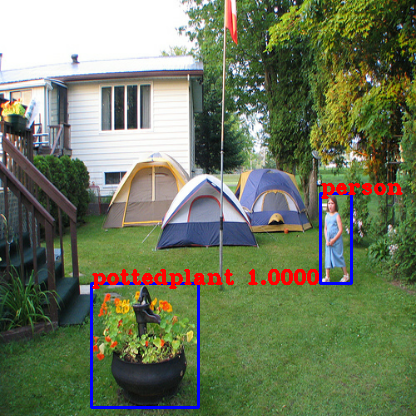

In [13]:
# from google.colab.patches import cv2_imshow
i = 141

dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
for image, labels in dataset.take(i):
    boxes = []
    scores = []
    classes = []
    img = tf.expand_dims(image, 0)
    img = transform_images(img, FLAGS.size)
    boxes, scores, classes, nums = yolo(img)
    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2_imshow(img)

dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
for image, labels in dataset.take(i):
    boxes = []
    scores = []
    classes = []
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue
        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2_imshow(img)

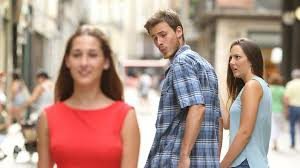

In [14]:
FLAGS.image = '/content/yolov3-tf2/data/girl.png'
FLAGS.image = '/content/yolov3-tf2/data/meme2.jpeg'

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

boxes, scores, classes, nums = yolo(img)

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

cv2_imshow(img)

In [0]:
# YOLOV3_LAYER_LIST = [
#     'yolo_darknet',
#     'yolo_conv_0',
#     'yolo_output_0',
#     'yolo_conv_1',
#     'yolo_output_1',
#     'yolo_conv_2',
#     'yolo_output_2',
# ]

# YOLOV3_TINY_LAYER_LIST = [
#     'yolo_darknet',
#     'yolo_conv_0',
#     'yolo_output_0',
#     'yolo_conv_1',
#     'yolo_output_1',
# ]

# def load_darknet_weights(model, weights_file, tiny=False):
#     wf = open(weights_file, 'rb')
#     major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

#     if tiny:
#         layers = YOLOV3_TINY_LAYER_LIST
#     else:
#         layers = YOLOV3_LAYER_LIST

#     for layer_name in layers:
#         sub_model = model.get_layer(layer_name)
#         for i, layer in enumerate(sub_model.layers):
#             if not layer.name.startswith('conv2d'):
#                 continue
#             batch_norm = None
#             if i + 1 < len(sub_model.layers) and \
#                     sub_model.layers[i + 1].name.startswith('batch_norm'):
#                 batch_norm = sub_model.layers[i + 1]

#             logging.info("{}/{} {}".format(
#                 sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

#             filters = layer.filters
#             size = layer.kernel_size[0]
#             in_dim = layer.input_shape[-1]

#             if batch_norm is None:
#                 conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
#             else:
#                 # darknet [beta, gamma, mean, variance]
#                 bn_weights = np.fromfile(
#                     wf, dtype=np.float32, count=4 * filters)
#                 # tf [gamma, beta, mean, variance]
#                 bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

#             # darknet shape (out_dim, in_dim, height, width)
#             conv_shape = (filters, in_dim, size, size)
#             conv_weights = np.fromfile(
#                 wf, dtype=np.float32, count=np.product(conv_shape))
#             # tf shape (height, width, in_dim, out_dim)
#             conv_weights = conv_weights.reshape(
#                 conv_shape).transpose([2, 3, 1, 0])

#             if batch_norm is None:
#                 layer.set_weights([conv_weights, conv_bias])
#             else:
#                 layer.set_weights([conv_weights])
#                 batch_norm.set_weights(bn_weights)

#     # assert len(wf.read()) == 0, 'failed to read all data'
#     wf.close()

In [0]:
output_1, output_2, output_3 = 'yolo_output_0', 'yolo_output_1', 'yolo_output_2'
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10)) 
    plt.plot(np.arange(0, epoch), his.history['loss'], 'k', label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['val_loss'], 'k--', label='val_loss')
    plt.plot(np.arange(0, epoch), his.history[f'{output_1}_loss'], 'r', label=f'train_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_2}_loss'], 'g', label=f'train_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_3}_loss'], 'b', label=f'train_{output_3}')
    
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_1}_loss'], 'r--', label=f'val_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_2}_loss'], 'g--', label=f'val_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_3}_loss'], 'b--', label=f'val_{output_3}')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10))
    plt.yticks(np.arange(0.1,1.05,0.01))
    plt.xticks(np.arange(0,61,1))
    plt.plot(np.arange(0, epoch), his.history[f'{output_1}_accuracy'], 'r', label=f'train_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_2}_accuracy'], 'g', label=f'train_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_3}_accuracy'], 'b', label=f'train_{output_3}')
    
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_1}_accuracy'], 'r--', label=f'val_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_2}_accuracy'], 'g--', label=f'val_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_3}_accuracy'], 'b--', label=f'val_{output_3}')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [0]:
plot_acc(history, epoch_num, 'Training Dataset: ')
plot_loss(history, epoch_num, 'Training Dataset: ')

plt.figure()
plt.plot(history.epoch, history.history['lr'])